In [1]:
import threading
import psutil
import shelve
import pickle
import sys
import h5py
import csv
import os
import shutil
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation

import neuroml as nml
import neuroml.writers as writers
from neuroml.utils import validate_neuroml2
import random
random.seed(12345)
from neuroml.nml.nml import parse as nmlparse
import eden_tools
dir(eden_tools)

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
os.getcwd()

print(f'Threads: {threading.active_count()}')

Threads: 5


/opt/conda/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


In [2]:
os.remove(nmlfile)
os.remove(LEMS_file)



NameError: name 'nmlfile' is not defined

In [3]:
path = os.getcwd()
cell_id = 'C51A'
Temp = 37
net_id = "network_of_%s"%cell_id    
net_doc = nml.NeuroMLDocument(id='net_'+str(cell_id))
results = []
channel_dict = dict(na_s_soma=0, kdr_soma=1, k_soma=2, cal_soma=3, BK_soma=4, cah_dend=5, kca_dend=6, h_dend=7, cacc_dend=8, na_axon=9, k_axon=10)



In [4]:
#include cell file from ../Cells/
cellfile = nml.IncludeType(href='../Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
net_doc.includes.append(cellfile)

#create network
net = nml.Network(id=net_id, type="networkWithTemperature", temperature=str(Temp)+"degC")
net_doc.networks.append(net)

#create population
pop = nml.Population(id='population_of_%s'%cell_id,component=cell_id,type='populationList',size='1')
net.populations.append(pop)

loc = nml.Location(x='0',y='0',z='0')
inst = nml.Instance(id='0',location=loc)
pop.instances.append(inst)

#include current clamp 
t_delay = 50
t_duration = 50
Amp = '-0.0nA'

Iclamp0 = nml.PulseGenerator(id='iclamp0',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
net_doc.pulse_generators.append(Iclamp0)

Iclamp1 = nml.PulseGenerator(id='iclamp1',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
net_doc.pulse_generators.append(Iclamp1)


#add Iclamp to cell
#input_list = nml.InputList(id='Iclamp0', component=Iclamp0.id, populations=pop.id)
#input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
#input_list.input.append(input)
#net.input_lists.append(input_list)

#change segment_id to change the compartment you stimulate
input_list = nml.InputList(id='Iclamp1', component=Iclamp1.id, populations=pop.id)
input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="69", destination="synapses")
input_list.input.append(input)
input = nml.Input(id='1', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="69", destination="synapses")
input_list.input.append(input)
net.input_lists.append(input_list)



#write the network file
net_file_name = 'nml_'+cell_id+'.net.nml'
writers.NeuroMLWriter.write(net_doc,net_file_name)
shutil.move(path+'/'+str(net_file_name), path+'/pynmlNetworks')





'/home/jovyan/work/NeuroML_Examples/Rocher/pynmlNetworks/nml_C51A.net.nml'

In [5]:
#redefine net and cell in case you don't run the above code segment
sim_id = 'Test'
length = 10000
step = 0.025

dend_channel = ["cah_dend/cah/r/q", "kca_dend/kca/z/q", "h_dend/h/n/q", "cacc_dend/cacc/m/q"]
axon_channel = ["na_axon/na_a/m/q", "na_axon/na_a/h/q", "k_axon/k/n/q"]
soma_channel = ["na_s_soma/na_s/m/q", "na_s_soma/na_s/h/q", "kdr_soma/kdr/n/q", "k_soma/k/n/q", "cal_soma/cal/k/q", "cal_soma/cal/l/q", "BK_soma/BK/c/q"]
recorded_segment = 0
recorded_segment1 = 69
recorded_segment2 = 8
recorded_segment3 = 0
recorded_variable1 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/v"
recorded_variable2 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/v"
recorded_variable3 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment3)+"/v"

nmlfile = './pynmlNetworks/nml_'+cell_id+'.net.nml'  #include_neuroml2_file duplicates the path if you use path+ and does not find the file if you use ../
LEMS = LEMSSimulation(sim_id, length , step , target = "network_of_%s"%cell_id)
LEMS.include_neuroml2_file(nmlfile)
#LEMS.set_report_file('SimStat.txt')                                   # not necessary but out of interest to see EDEN vs NEURON 




#disp_0 = 'Voltage'
#LEMS.create_display(disp_0, 'Voltage trace', '-100', '70' )
#LEMS.add_line_to_display(disp_0, recorded_segment, recorded_variable)

#traces0 = 'voltage traces'
#LEMS.create_output_file(traces0,"%s.v.dat"%sim_id)
#LEMS.add_column_to_output_file(traces0, recorded_segment, recorded_variable)
#disp1 = 'Gates Dendrite'
#disp2 = 'Gates Axon'
#disp = 'Gates Soma'
#traces1 = 'Gate_file_dendrite'
#traces2 = 'Gate_file_axon'
#traces = 'Gate_file_soma'

#LEMS.create_display(disp, "Soma gate variables", "0", "1")
#LEMS.create_output_file(traces, "%s.Soma_gates.dat"%sim_id)

#LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
#LEMS.create_output_file(traces1, "%s.Dendrite_gates.dat"%sim_id)

#LEMS.create_display(disp2, "Axon gate variables", "0", "1")
#LEMS.create_output_file(traces2, "%s.Axon_gates.dat"%sim_id)

#for i in range(len(dend_channel)):
    #disp1 = 'Gates Dendrite'
    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
   # LEMS.add_line_to_display(disp1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))

    #traces1 = 'Gate_file_dendrite'
    #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
   # LEMS.add_column_to_output_file(traces1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))
    
#for i in range(len(axon_channel)):
    #disp2 = 'Gates Axon'
    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
   # LEMS.add_line_to_display(disp2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))

    #traces2 = 'Gate_file_axon'
    #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
 #   LEMS.add_column_to_output_file(traces2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))   
    
#for i in range(len(soma_channel)):
    #disp2 = 'Gates Axon'
    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
#    LEMS.add_line_to_display(disp, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))

    #traces2 = 'Gate_file_axon'
    #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
#    LEMS.add_column_to_output_file(traces, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))        
    


disp4 = 'Voltage'
LEMS.create_display(disp4, "Dendrite trace", "-100", "70")
LEMS.add_line_to_display(disp4, recorded_segment1, recorded_variable1)
LEMS.add_line_to_display(disp4, recorded_segment2, recorded_variable2)
LEMS.add_line_to_display(disp4, recorded_segment3, recorded_variable3)

traces4 = 'file'
LEMS.create_output_file(traces4, "%s.vd.dat"%sim_id)
LEMS.add_column_to_output_file(traces4, recorded_segment1, recorded_variable1)
LEMS.add_column_to_output_file(traces4, recorded_segment2, recorded_variable2)
LEMS.add_column_to_output_file(traces4, recorded_segment3, recorded_variable3)

#disp5 = 'Caconc'
#LEMS.create_display(disp5, "Caconc trace", "-100", "70")
#LEMS.add_line_to_display(disp5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(69)+"/caConc")

#traces5 = 'Caconc file'
#LEMS.create_output_file(traces5, "%s.caconc.dat"%sim_id)
#LEMS.add_column_to_output_file(traces5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(69)+"/caConc")


#disp5 = 'Calcium Concentration'
#LEMS.create_display(disp5, "Calcium concentration", "0", "1")
#LEMS.add_line_to_display(disp, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/caConc")

#traces5 = 'Ca conc file'
#LEMS.create_output_file(traces5, "%scalconc.dat"%sim_id)
#LEMS.add_column_to_output_file(traces5, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/caConc")        
    






filename = 'LEMS_'+str(sim_id)+'_'+str(cell_id)+'.xml'
LEMS.save_to_file(file_name = filename )

#edit the wrong path generated by LEMS.include_neuroml2_file
fin = open(path+'/'+str(filename), 'rt')
data = fin.read()
data = data.replace('<Include file="./pynmlNetworks/', '<Include file="../pynmlNetworks/')
data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
fin.close()
fin = open(path+'/'+str(filename), 'wt')
fin.write(data)
fin.close()

shutil.move(path+'/'+str(filename), path+'/LEMSFILES')


pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A.xml


Error: Destination path '/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES/LEMS_Test_C51A.xml' already exists

In [39]:
simnr = int(5) #must be even cuz code bad

#Set somatic channel densities
na_s_soma =[]
kdr_soma=[]
k_soma=[]
cal_soma=[]
BK_soma=[]

#set dendritic channel densities
cah_dend=[]
kca_dend=[]
h_dend=[]
cacc_dend = []

#set axonic channel densities
na_axon=[]
k_axon=[]

for g in range(simnr):
    na_s_soma.append(30)
    kdr_soma.append(30)
    k_soma.append(15)
    cal_soma.append(80)
    BK_soma.append(0)

    #set dendritic channel densities
    cah_dend.append(10)
    kca_dend.append(500)
    h_dend.append(25)
    cacc_dend.append(0)

    #set axonic channel densities
    na_axon.append(100)
    k_axon.append(200)
    
#cah_dend = np.linspace(0,100,simnr)
cal_soma = np.linspace(50,1,simnr)
cacc_dend = np.linspace(0,1,simnr)
#h_dend =  np.linspace(25,100,simnr)
#cah_dend = np.linspace(0,50,simnr//2)
#kca_dend = np.linspace(0,500,simnr//2)
#cah_dend = np.append(cah_dend, np.flip(cah_dend)[1:])
#kca_dend = np.append(kca_dend, np.flip(kca_dend)[1:])
cacc_dend_matrix = np.transpose(np.broadcast_to(cacc_dend,(simnr,len(cacc_dend))))

if len(kca_dend) == len(na_s_soma):
    print('you may proceed')
else:
    print('your parameter vectors have unequal lenght dummy')


LEMS_file = f'LEMSFILES/{filename}'
results=[]
count = 1
for i in range(simnr):

    cacc_dend = cacc_dend_matrix[i]
    intermediate_results = []
    for g in range(simnr):
        
        doc = nmlparse('Another_Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')

        #somatic channel densities
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_s_soma']].cond_density = str(na_s_soma[g])+' mS_per_cm2'
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kdr_soma']].cond_density = str(kdr_soma[g])+' mS_per_cm2'
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_soma']].cond_density = str(k_soma[g])+' mS_per_cm2'
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cal_soma']].cond_density = str(cal_soma[g])+' mS_per_cm2'
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['BK_soma']].cond_density = str(BK_soma[g])+' mS_per_cm2'

        #dendritic channel densities    
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cah_dend']].cond_density = str(cah_dend[g])+' mS_per_cm2'
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kca_dend']].cond_density = str(kca_dend[g])+' mS_per_cm2'    
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['h_dend']].cond_density = str(h_dend[g])+' mS_per_cm2'
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cacc_dend']].cond_density = str(cacc_dend[g])+' mS_per_cm2'

        #axonic channel densities
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_axon']].cond_density = str(na_axon[g])+' mS_per_cm2'
        doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_axon']].cond_density = str(k_axon[g])+' mS_per_cm2'

        #leak channel
        #doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['leak']].cond_density = str(leak[g])+' mS_per_cm2'
        writers.NeuroMLWriter.write(doc, 'Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')



        #out_dir = path+'\Simulation result'
        out_dir,rel_filename = os.path.split(LEMS_file)
        print(out_dir)
        print(rel_filename)


        
        print(f'You are running simulation {count} of {simnr*simnr} \n')

        #results = {}
        #results = pynml.run_lems_with_jneuroml_neuron(
        #        LEMS_file, verbose=False, nogui=True, load_saved_data=True, exec_in_dir= out_dir,
        #        max_memory='1000M')


        LEMS_file = f'LEMSFILES/{filename}'
    
        results_Neuron = eden_tools.runNeuron( LEMS_file, verbose=True )
        print("The CPU usage is : ",psutil.getloadavg())
        print('RAM memory % used:', psutil.virtual_memory()[2])
        intermediate_results.append(dict(results_Neuron))
        
        results_Neuron = None
        count = count+1
    
    #results.append(intermediate_results)
    with open(f'results{i}.pickle', 'wb+') as handle:
            pickle.dump(intermediate_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    intermediate_results = None

you may proceed
LEMSFILES
LEMS_Test_C51A.xml
You are running simulation 1 of 25 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.09 seconds
The CPU usage is :  (0.77, 1.22, 1.02)
RAM memory % used: 57.6
LEMSFILES
LEMS_Test_C51A.xml
You are running simulation 2 of 25 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 9.22 seconds
The CPU usage is :  (1.62, 1.39, 1.08)
RAM memory % used: 57.6
LEMSFILES
LEMS_Test_C51A.xml
You are running simulation 3 of 25 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.14 seconds
The CPU usage is :  (1.8, 1.61, 1.22)
RAM memory % used: 57.8
LEMSFILES
LEMS_Test_C51A.xml
You are running simulation 24 of 25 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.32 seconds
The CPU usage is :  (2.28, 1.72, 1.26)
RAM memory % used: 58.0
LEMSFILES
LEMS_Test_C51A.xml
You are running simulation 25 of 25 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMS_Test_C51A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 7.70 seconds
The CPU usage is :  (

In [40]:
#with open('results.pickle', 'wb+') as handle:
#           pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
results = []
for i in range(simnr):
    with open(f'results{i}.pickle', 'rb') as handle:
        results.append(pickle.load(handle))      
        os.remove(f'results{i}.pickle')


In [41]:
 %matplotlib inline

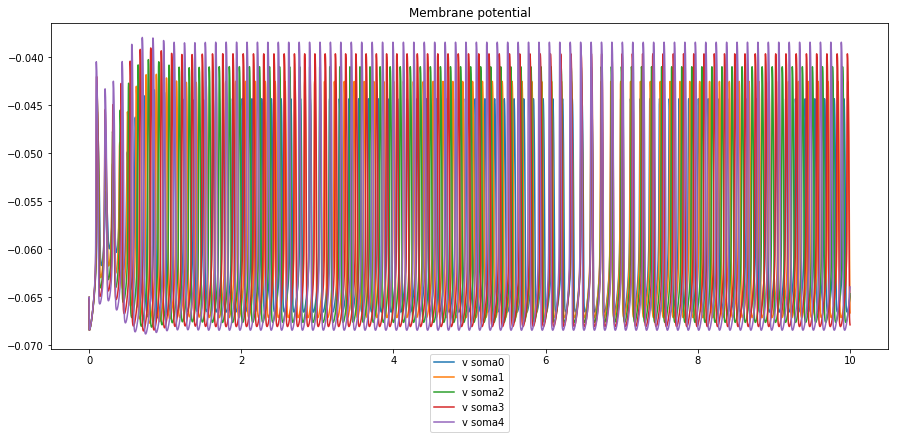

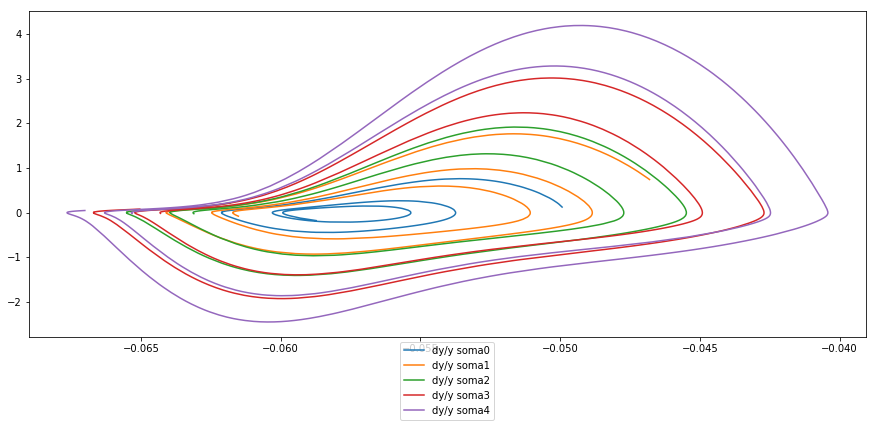

KeyError: 'population_of_C51A/0/C51A/69/caConc'

<Figure size 1080x432 with 0 Axes>

In [42]:
from numpy import diff
for g in range(len(results[0])):
    results_Neuron = results[0][g]
    plt.figure(5, figsize=(15,6))
    plt.plot(results_Neuron['t'], results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/v'], label = "v soma"+str(g))
    #plt.plot(results_Neuron['t'], results_Neuron['population_of_C15A/0/C15A/10/v'], label = "v dendrite")
    #plt.plot(results_Neuron['t'], results_Neuron['population_of_C15A/0/C15A/69/v'], label ="v axon")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    plt.title('Membrane potential')
plt.show() 


plt.figure(6, figsize=(15,6))

for g in range(len(results[0])):
    dx = 0.025*(10**-3)
    results_Neuron = results[0][g]
    y = results_Neuron[f'population_of_{cell_id}/0/{cell_id}/0/v']
    dy = diff(y)/dx
    plt.plot(y[10000:20000],dy[10000:20000], label = "dy/y soma"+str(g))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    
    
plt.show() 

plt.figure(7, figsize=(15,6))
for g in range(len(results[0])):
    results_Neuron = results[0][g]
    plt.plot(results_Neuron[f'population_of_{cell_id}/0/{cell_id}/69/caConc'], label = "caConc dendrite"+str(g))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    
    plt.title('Caconc')
plt.savefig('caconc.png')    
plt.show() 


KeyError: 'population_of_C51A/0/C51A/69/biophys/membraneProperties/cah_dend/cah/r/q'

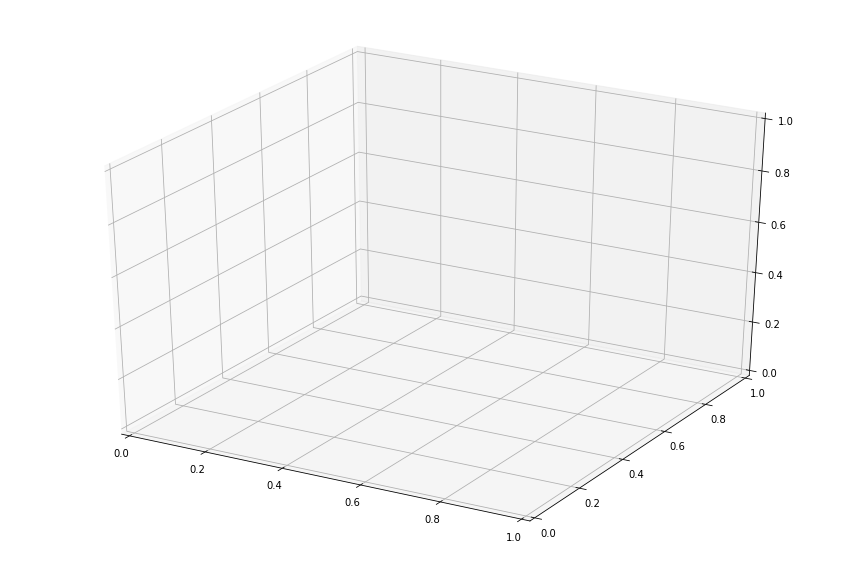

In [43]:
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

plt.figure(figsize=(15,10))
ax = plt.subplot(projection='3d')
x = []
y = []
z = []
for i in range(len(results)):
    for g in range(len(results[1])):
        x.append(results[i][g][f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/cah_dend/cah/r/q'])
        y.append(results[i][g][f'population_of_{cell_id}/0/{cell_id}/69/biophys/membraneProperties/kca_dend/kca/z/q'])
        z.append(np.ones((len(x[0])))*g+ 10*i)

    
    
    for g in range(len(z)):    
        ax.plot(x[g], y[g], z[g])



TypeError: Invalid dimensions for image data

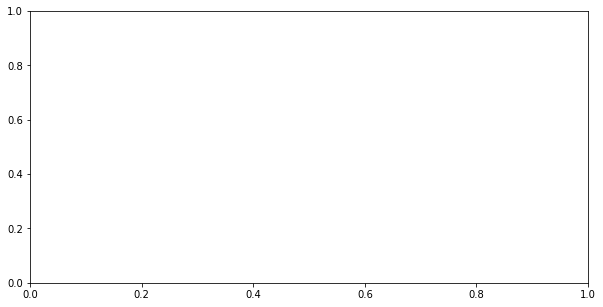

In [44]:
plt.figure(figsize=(10,5))
plt.imshow(x, interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(y, interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

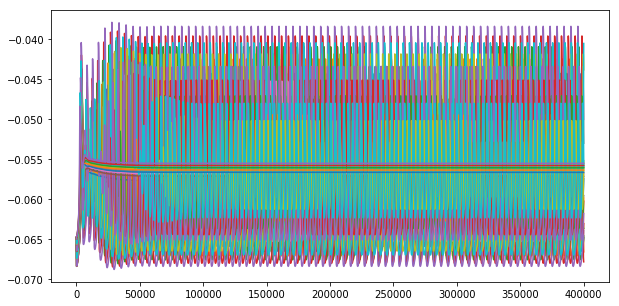

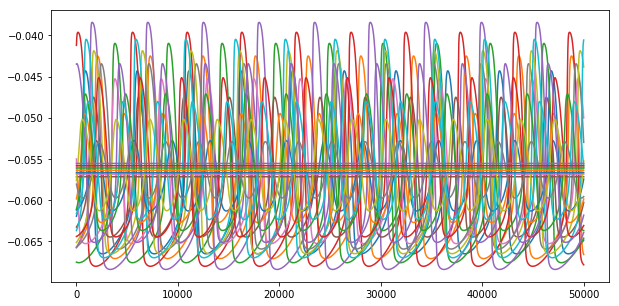

In [45]:
plt.figure(figsize=(10,5))
for i in range(len(results)):
    for g in range(len(results[1])):
        plt.plot(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'])
        
plt.figure(figsize=(10,5))
for i in range(len(results)):
    for g in range(len(results[1])):
        plt.plot(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000])

In [46]:
from numpy import *
amp = np.zeros((len(results),len(results[1])))
maxim = np.zeros((len(results),len(results[1])))
minim = np.zeros((len(results),len(results[1])))
for i in range(len(results)):
    for g in range(len(results[1])):
        amp[i,g] = (max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000]) - min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000]))
        maxim[i,g] = max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000])
        minim[i,g] = min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000])
where_are_NaNs = isnan(amp)
amp[where_are_NaNs] = 0

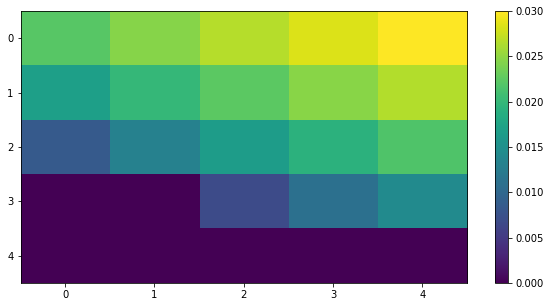

In [47]:
plt.figure(figsize=(10,5))
plt.imshow(amp,interpolation='none', aspect='auto')
plt.colorbar()
plt.show()



In [75]:
x = []
z=[]
y=[]
thresh = 0.04
z = np.zeros((len(results),len(results[1])))
for i in range(len(results)):
    for g in range(len(results[1])):
        z[i,g] = (max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][15000:35000]) - min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][15000:35000]))
    x.append(np.ones((len(z[0])))*i)
    
       
y = np.linspace(0,len(z[:,0]),len(z[:,0]))


where_are_NaNs = isnan(z)
z[where_are_NaNs] = 0

#super_threshold_indices = z > thresh
#z[super_threshold_indices] = 0.02

<IPython.core.display.Javascript object>


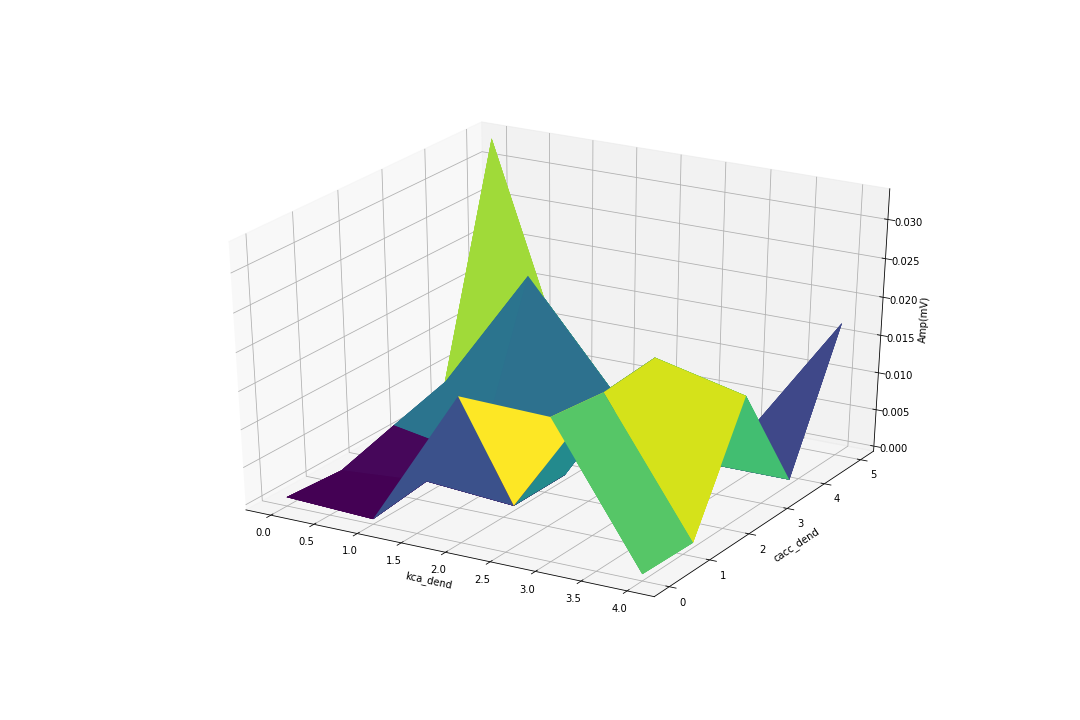

Text(0.5,0,'Amp(mV)')

In [76]:
#%matplotlib inline
%matplotlib notebook
plt.figure(figsize=(15,10))
ax = plt.subplot(projection='3d')

for g in range(len(z)):
    ax.plot_surface(x,y,  z, cmap='viridis', linewidth=0)
    plt.show()
ax.set_xlabel('kca_dend')
ax.set_ylabel('cacc_dend')
ax.set_zlabel('Amp(mV)')

5

<IPython.core.display.Javascript object>


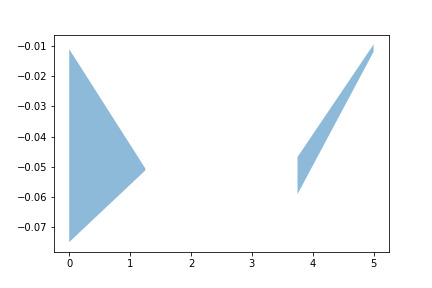

<IPython.core.display.Javascript object>


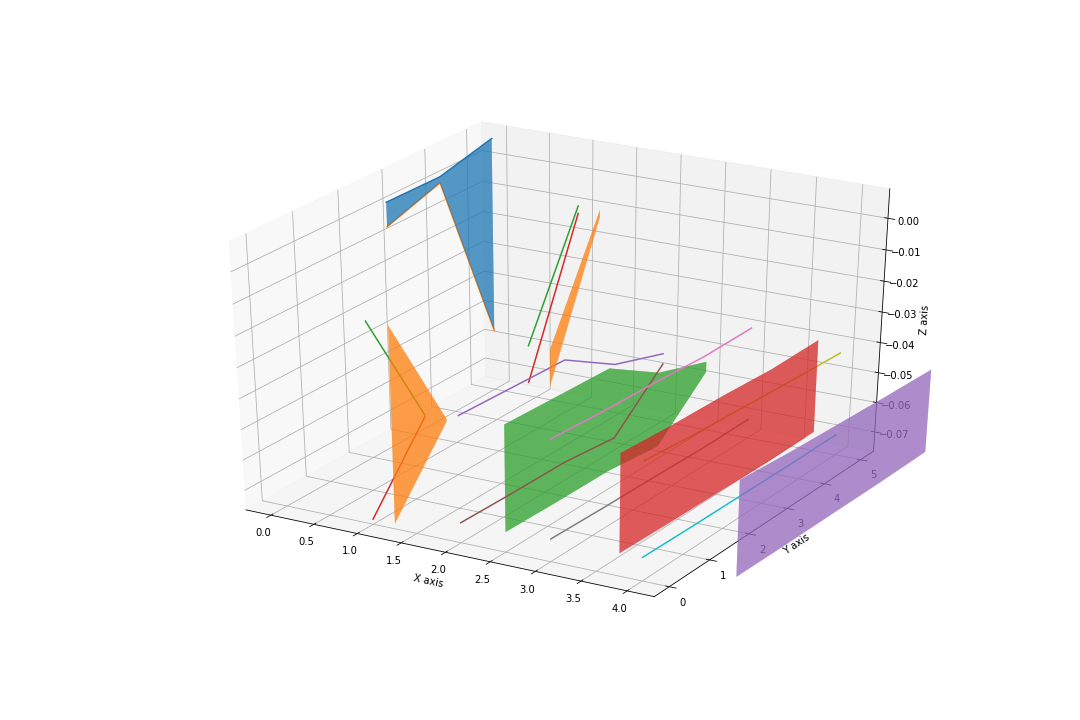

Text(0.5,0,'Z axis')

In [18]:
#plt.plot(amp[1,:])

fig, ax = plt.subplots(1)

#for g in range(len(results[1])):
g = 1
t = np.linspace(0,len(amp[1,:]),len(amp[1,:]))
#ax.plot(t,amp[g,:]/2)
#ax.plot(t,amp[g,:] + maxim[g,:])
#ax.plot(t,amp[g,:] - minim[g,:])
ax.fill_between(t,maxim[g,:],minim[g,:], alpha=0.5)
    
y = []    
plt.figure(figsize=(15,10))
ax = plt.subplot(projection='3d')

for i in range(len(results)):
    for g in range(len(results[1])):    
        y.append(np.ones(len(amp[:,1]))*g)
        #y = np.ones((len(amp[:,1])))

for g in range(len(results[1])):
    ax.plot(y[g],t, maxim[g,:])
    ax.plot(y[g],t, minim[g,:])
    ax.add_collection3d(plt.fill_between(t,minim[g,:],maxim[g,:], alpha=0.5), zs=t[g], zdir='x')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')